In [1]:
from collections import defaultdict, OrderedDict
from lxml import etree
from discoursegraphs import t
from discoursegraphs.readwrite.rst.rs3 import dt, extract_relationtypes, get_rs3_data
from discoursegraphs.readwrite.tree import get_position
from rstviewer import embed_rs3_image, embed_rs3str_image

In [2]:
RS3_EXAMPLE_FILE = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-1818.rs3'

# Testing

In [3]:
cdict, edict, ordered_edus = get_rs3_data(RS3_EXAMPLE_FILE)
edu_set = set(ordered_edus)

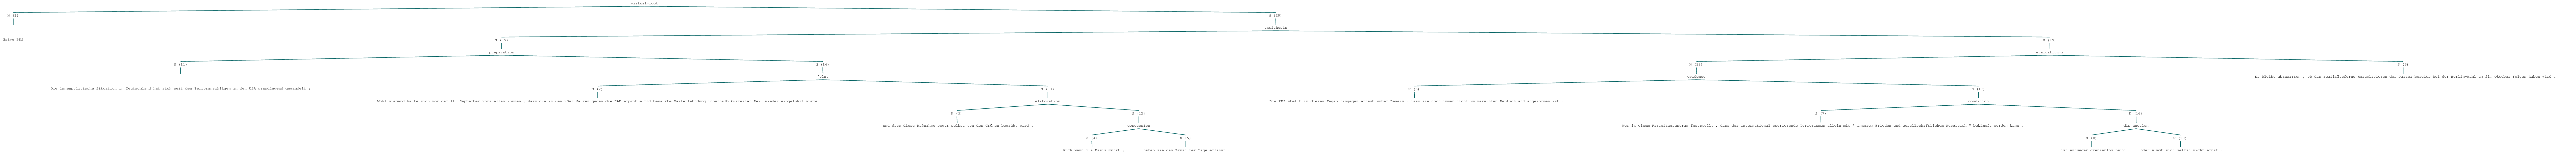

In [4]:
dt(cdict, edict, ordered_edus, start_node=None)

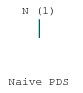

In [5]:
dt(cdict, edict, ordered_edus, start_node='1') # OK

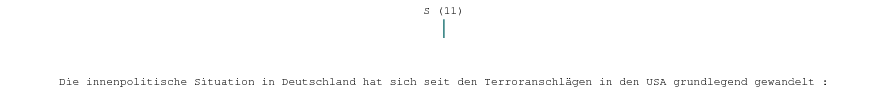

In [6]:
dt(cdict, edict, ordered_edus, start_node='11') # OK

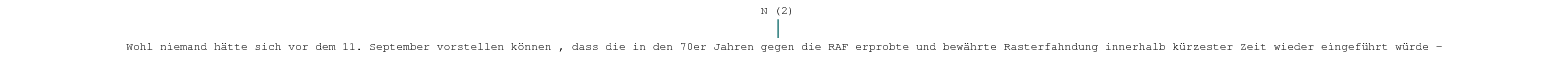

In [7]:
dt(cdict, edict, ordered_edus, start_node='2') # OK

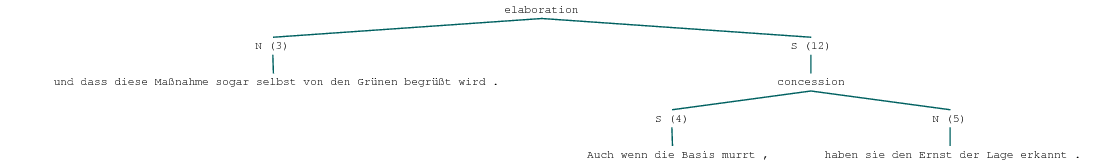

In [8]:
dt(cdict, edict, ordered_edus, start_node='3') # OK

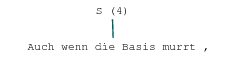

In [9]:
dt(cdict, edict, ordered_edus, start_node='4') # OK

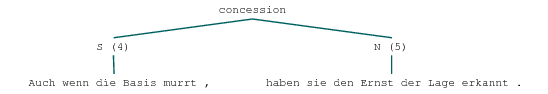

In [10]:
dt(cdict, edict, ordered_edus, start_node='5') # OK

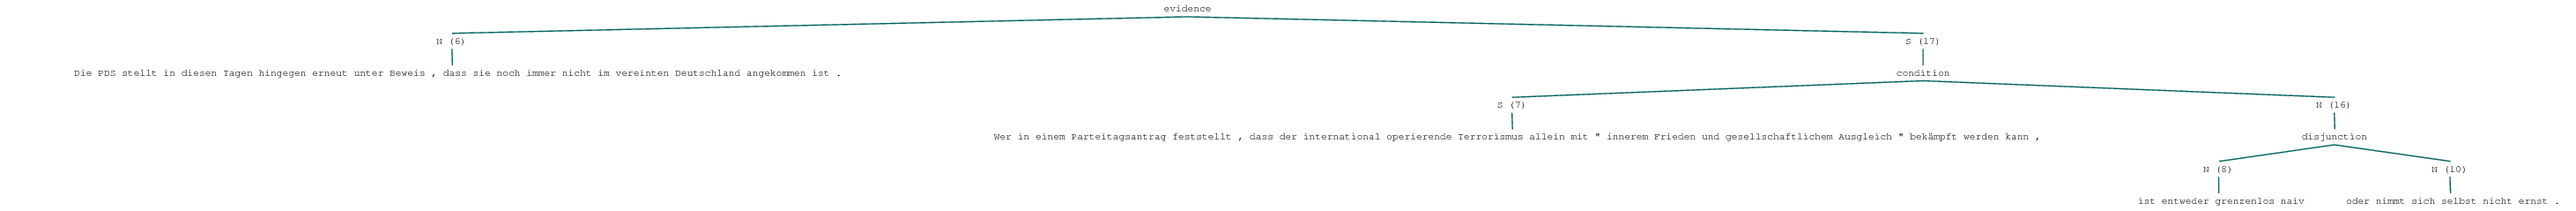

In [11]:
dt(cdict, edict, ordered_edus, start_node='6') # OK

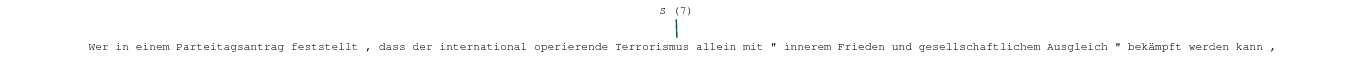

In [12]:
dt(cdict, edict, ordered_edus, start_node='7') # OK

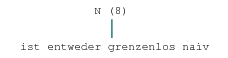

In [13]:
dt(cdict, edict, ordered_edus, start_node='8') # OK

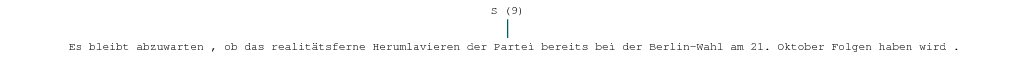

In [14]:
dt(cdict, edict, ordered_edus, start_node='9') # OK

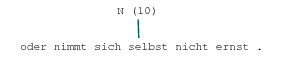

In [15]:
dt(cdict, edict, ordered_edus, start_node='10') # OK

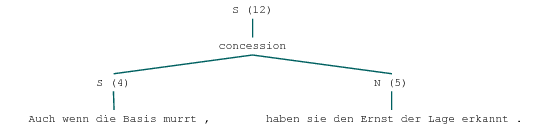

In [16]:
dt(cdict, edict, ordered_edus, start_node='12') # OK

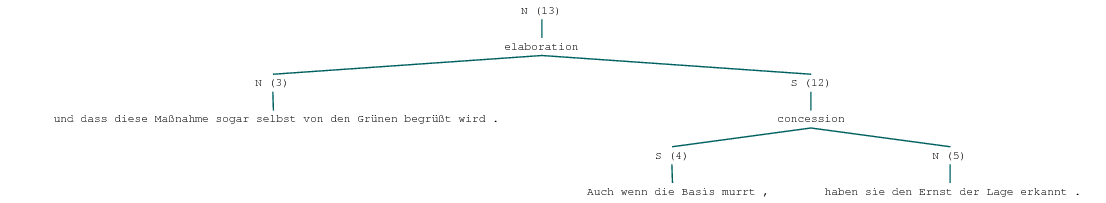

In [17]:
dt(cdict, edict, ordered_edus, start_node='13') # OK

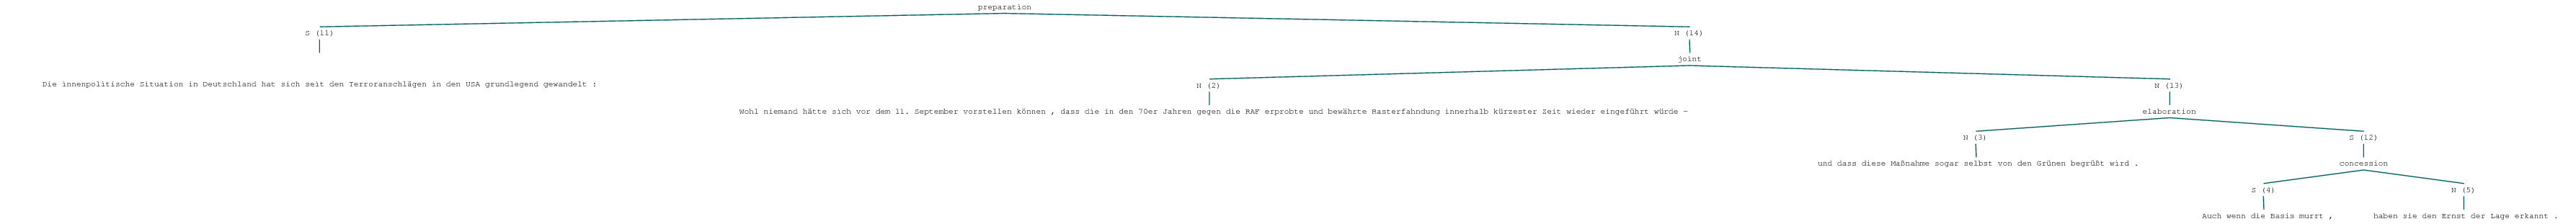

In [18]:
dt(cdict, edict, ordered_edus, start_node='14') # OK

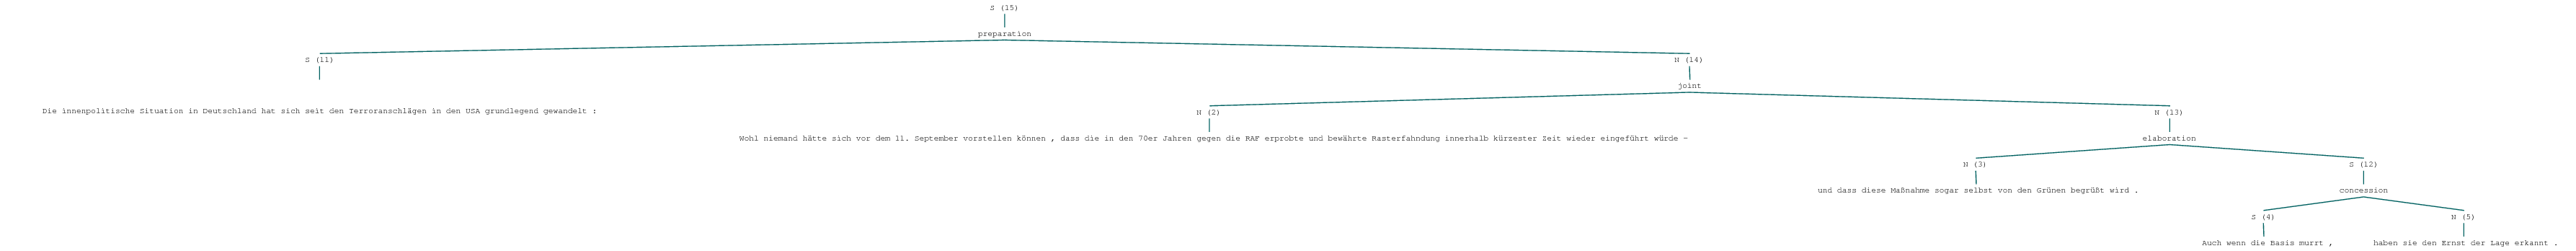

In [19]:
dt(cdict, edict, ordered_edus, start_node='15') # OK

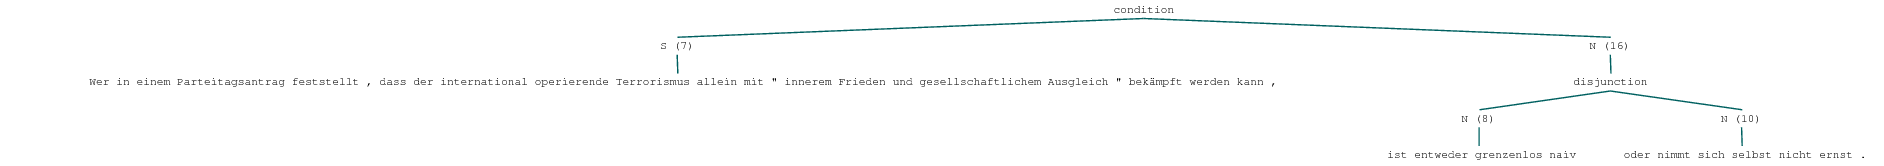

In [20]:
dt(cdict, edict, ordered_edus, start_node='16') # OK

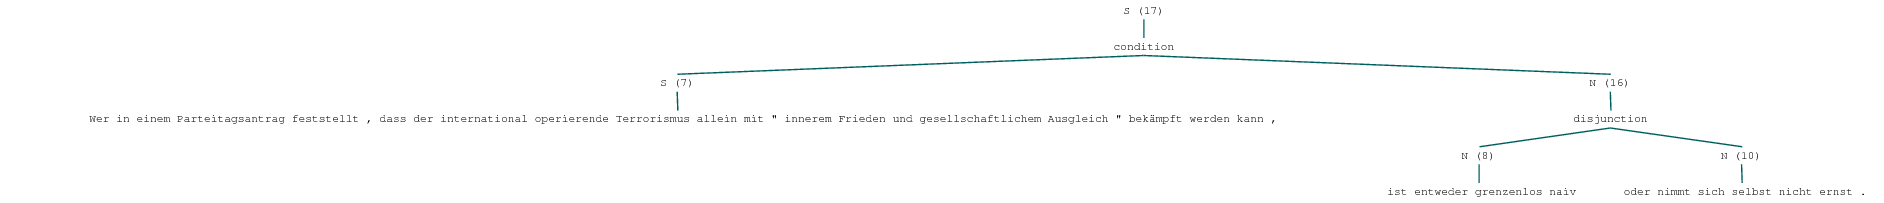

In [21]:
dt(cdict, edict, ordered_edus, start_node='17') # OK

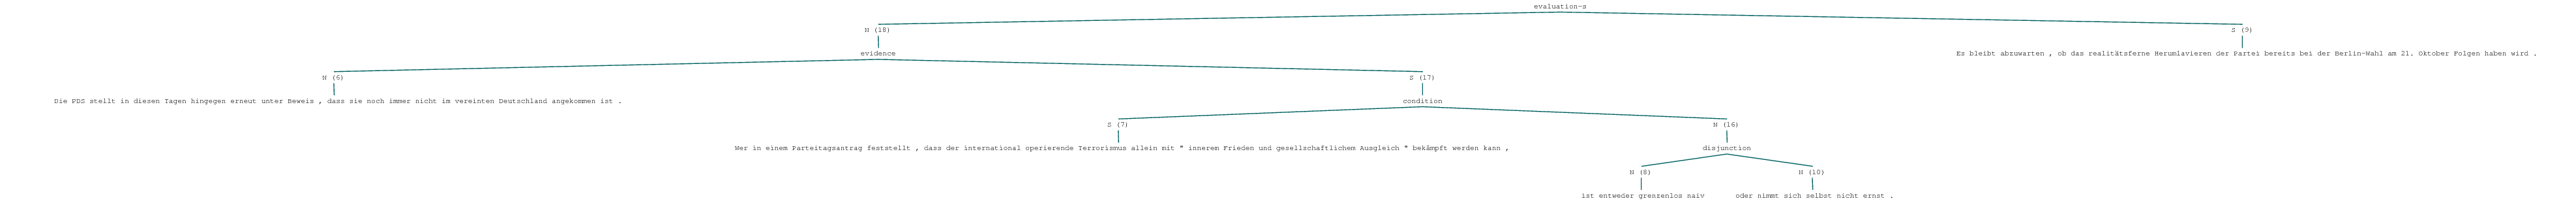

In [22]:
dt(cdict, edict, ordered_edus, start_node='18') # OK

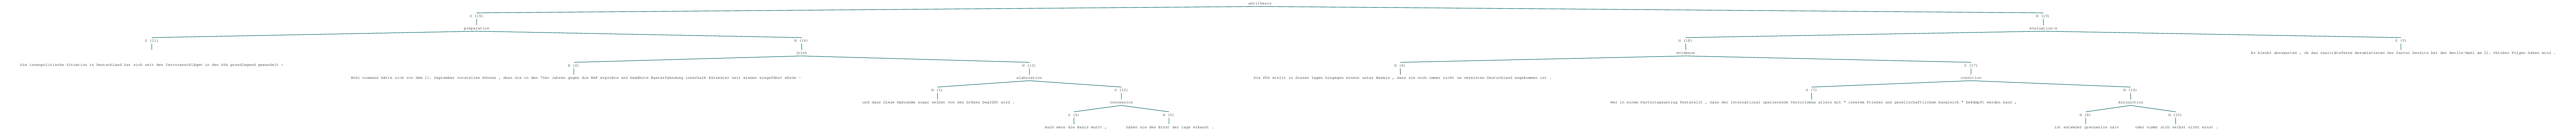

In [23]:
dt(cdict, edict, ordered_edus, start_node='19') # OK

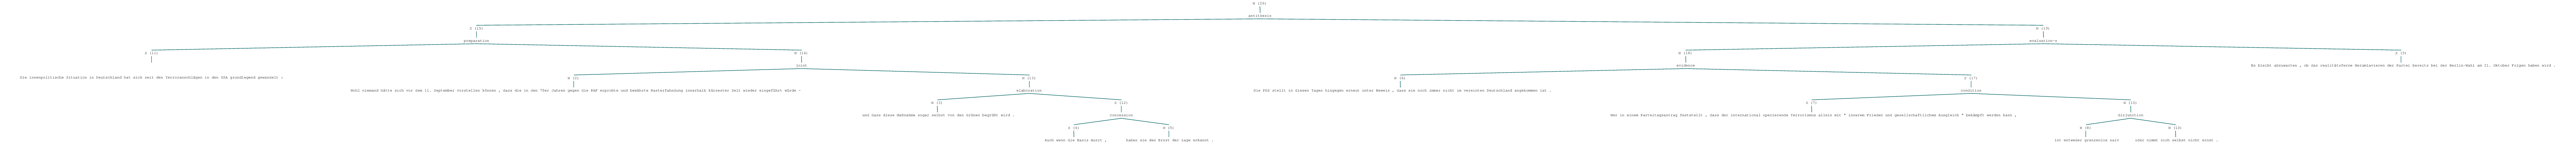

In [24]:
dt(cdict, edict, ordered_edus, start_node='20') # OK

# TODOs

## implement word-wrap
## only show node number in debug mode (otherwise: 'N' or 'S')

In [25]:
class RSTTree(object):
#     def __init__(self, root, children=None):
#         self.tree = t(root, children)
    def __init__(self, rs3_file, word_wrap=0):
        self.child_dict, self.elem_dict, self.edus = get_rs3_data(rs3_file)
        self.edu_set = set(self.edus)
        self.tree = dt(self.child_dict, self.elem_dict, self.edus)
        
    def _repr_png_(self):
        return self.tree._repr_png_()
    def __str__(self):
        return self.tree.__str__()

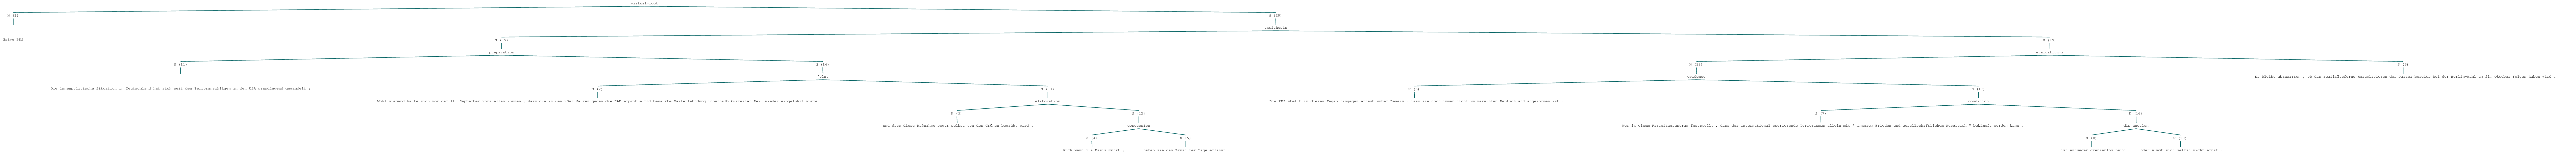

In [26]:
RSTTree(RS3_EXAMPLE_FILE)

# TODO: illegal trees for Manfred

In [27]:
# maz_4031 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3'

In [28]:
# TODO: show Manfred. Should be illegal: concession(6-9 -> 5) and concession(10-11 -> 5)!
# embed_rs3_image(maz_4031)

In [29]:
# maz_6728 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-6728.rs3'

In [30]:
# TODO: show Manfred. Should be illegal: reason(6-8 -> 2-5) AND evidence(9-11 -> 2-5)
# embed_rs3_image(maz_6728)

In [31]:
maz_18377 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-18377.rs3'

In [32]:
# embed_rs3_image(maz_18377)

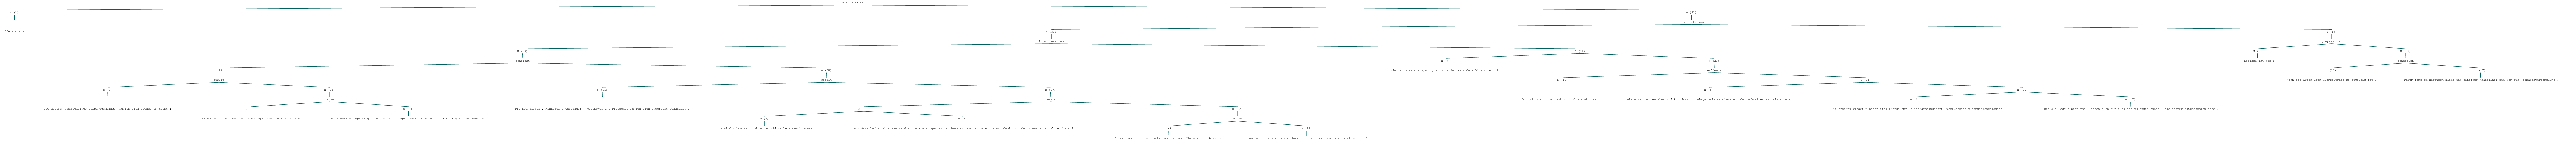

In [33]:
RSTTree(maz_18377)

In [34]:
maz_4031 = '/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3'

In [35]:
# cdict, edict, ordered_edus = get_rs3_data(maz_18377)
# edu_set = set(ordered_edus)

# get_position('17', cdict, ordered_edus, edu_set)
RSTTree(maz_4031)

AssertionError: 

In [36]:
import os
import traceback
from collections import Counter

from discoursegraphs.corpora import pcc

counter = Counter()
exceptions = Counter()
for rs3_file in pcc.rst:
    print rs3_file
    try:
        rt = RSTTree(rs3_file)
        counter["wins"] += 1
        print("OKAY")
    except Exception as e:
        print("FAIL")
        print traceback.format_exc()
        counter["fails"] += 1
        exceptions[repr(e)] += 1
        print

/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-18377.rs3
OKAY
/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/data/potsdam-commentary-corpus-2.0.0/rst/maz-4031.rs3
FAIL
Traceback (most recent call last):
  File "<ipython-input-36-51795106fab0>", line 12, in <module>
    rt = RSTTree(rs3_file)
  File "<ipython-input-25-7ef6fb2c236d>", line 7, in __init__
    self.tree = dt(self.child_dict, self.elem_dict, self.edus)
  File "/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/readwrite/rst/rs3.py", line 638, in dt
    for root_id in root_nodes]
  File "/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/readwrite/rst/rs3.py", line 715, in dt
    for mc in multinuc_child_ids])
  File "/usr/local/lib/python2.7/dist-packages/discoursegraphs-0.3.2-py2.7.egg/discoursegraphs/readwrite/rst/rs3.py", line 

In [37]:
print counter, "\n"
for e, count in exceptions.most_common():
    print e, count

Counter({'fails': 98, 'wins': 78}) 

AssertionError() 64
ValueError("A span group ('32') should not have > 2 children: ['9', '29', '35']",) 1
ValueError("A span group ('28') should not have > 2 children: ['10', '17', '27']",) 1
ValueError("A span group ('28') should not have > 2 children: ['12', '27', '30']",) 1
ValueError("A span group ('23') should not have > 2 children: ['12', '24', '22']",) 1
AssertionError("A multinuc segment (18) should not have children: ['40']",) 1
ValueError("A span group ('20') should not have > 2 children: ['6', '21', '25']",) 1
ValueError("A span group ('28') should not have > 2 children: ['8', '26', '27']",) 1
ValueError("A span group ('25') should not have > 2 children: ['8', '10', '11']",) 1
ValueError("A span group ('26') should not have > 2 children: ['22', '25', '28']",) 1
ValueError("A span group ('28') should not have > 2 children: ['23', '24', '26', '29']",) 1
ValueError("A span group ('22') should not have > 2 children: ['8', '9', '11']",) 1
Value